In [92]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.circuit import ParameterVector
from cuquantum import *
import time


In [93]:
poly_data = pd.read_csv("cyaninedye_dataset.csv")
columns_to_drop = poly_data.columns[0:2]
poly_data = poly_data.drop(columns=columns_to_drop, axis=1)
# ['HeteroatomCount.csv', 'AromaticRingCount.csv', 'HBondAcceptorCount.csv','RotatableBondCount.csv',  'DegreeOfUnsaturation.csv', 
#               'FractionCarbonSP3.csv',  'MaxDistance.csv','LongestPiChain.csv', 'MinEllipsoidLength.csv',
#                 'LinkerLength.csv','HeterocycleCount.csv', 'HBondDonorCount.csv']
data_train = poly_data.loc[:,["MolecularMass","MaxAbsorbanceWavelength"]]
label_name = "HBondAcceptorCount"
label_train = poly_data.loc[:,[label_name]]
print(label_train)
X_train, X_val, Y_train, Y_val = train_test_split(data_train, label_train, test_size = 0.2, random_state=255)


     HBondAcceptorCount
0                     8
1                     8
2                     7
3                     7
4                     8
..                  ...
142                   2
143                   3
144                   2
145                   3
146                   2

[147 rows x 1 columns]


In [94]:
def data_prepare(n_dim, sample_train, sample_test):
    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="full").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:100]
    sample_test = minmax_scale.transform(sample_test)[:50]
    return sample_train, sample_test
def svm_score(sample_train,labels_train,sample_val,labels_val):
    parameters = {'C':[1], 'gamma': [0.001, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 50, 100, 1000]}
    svc_grid_search = SVC(kernel="rbf")
    clf = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')
    clf.fit(sample_train,labels_train)
    result1=clf.score(sample_train,labels_train)
    result2=clf.score(sample_val,labels_val)
    return result1, result2


In [95]:
min_features = min(X_train.shape[1], X_val.shape[1])
# 假設 Y_train 和 Y_val 是連續值，我們將它們轉換為離散類別
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Y_train_binned = est.fit_transform(Y_train[:100].values.reshape(-1, 1)).ravel()
Y_val_binned = est.transform(Y_val[:50].values.reshape(-1, 1)).ravel()
for q in range(2,200,10):
    n_dim = min(q, min_features)    
    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
    score1, score2 = svm_score(data_train,Y_train_binned[:100],data_val,Y_val_binned[:50])
    print(n_dim,score1, score2)
for q in [200,300,400,500,600,784]:
    n_dim = min(q, min_features)    
    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
    score1, score2 = svm_score(data_train,Y_train_binned[:100],data_val,Y_val_binned[:50])
    print(n_dim,score1, score2)


2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8
2 0.71 0.8


---

## statevector simulation

In [96]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.circuit import ParameterVector
from cuquantum import *
import time


In [97]:
def data_prepare(n_dim, sample_train, sample_test):
    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="full").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:100]
    sample_test = minmax_scale.transform(sample_test)[:50]
    return sample_train, sample_test
def make_bsp(n_dim):
    param = ParameterVector("p",n_dim)
    bsp_qc = QuantumCircuit(n_dim)
    bsp_qc.h(list(range(n_dim)))
    i = 0
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(n_dim-1):
        bsp_qc.cx(0+i, 1+i)
        i+=1
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
    return bsp_qc
def all_circuits_parallel(y_t, x_t, indices_list, n_dim, kernel, num_cpu):
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        circuits = pool.starmap(kernel.construct_circuit, [(y_t[i1-1], x_t[i2-1],False) for i1, i2 in indices_list])
    return circuits
def kernel_matrix_svsm(y_t, x_t, circuit,indices_list, simulator, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i = -1
    for i1, i2 in indices_list:
        i += 1
        qc = circuit[i]
        qc.save_statevector()
        circ = transpile(qc, simulator)
        result = simulator.run(circ).result()
        amp = abs(result.get_statevector()[0]) ** 2
        kernel_matrix[i1-1][i2-1] = np.round(amp,8)
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix


In [98]:
simulator = Aer.get_backend('aer_simulator_statevector')
simulator.set_option('cusvaer_enable', False)
simulator.set_option('precision', 'double')


In [99]:
n_dim = 2
data_train, data_val  = data_prepare(n_dim, X_train, X_val)


In [100]:
bsp_qc = make_bsp(n_dim)
bsp_kernel_svsm = QuantumKernel(feature_map=bsp_qc, quantum_instance=simulator)


In [101]:
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)


(4950, 3000)

In [102]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, bsp_kernel_svsm, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, bsp_kernel_svsm, 10)
len(circuit_train),len(circuit_val)


(4950, 3000)

In [103]:
svsm_kernel_matrix_train = kernel_matrix_svsm(data_train, data_train, circuit_train, indices_list_t, simulator, mode="train")
svsm_kernel_matrix_test  = kernel_matrix_svsm(data_val, data_train, circuit_val, indices_list_v, simulator)


In [104]:
matrix_train = bsp_kernel_svsm.evaluate(x_vec=data_train)
(svsm_kernel_matrix_train-matrix_train).max()


4.998707225922772e-09

In [105]:
matrix_test = bsp_kernel_svsm.evaluate(data_val,data_train)
(svsm_kernel_matrix_test-matrix_test).max()


4.999235025948678e-09

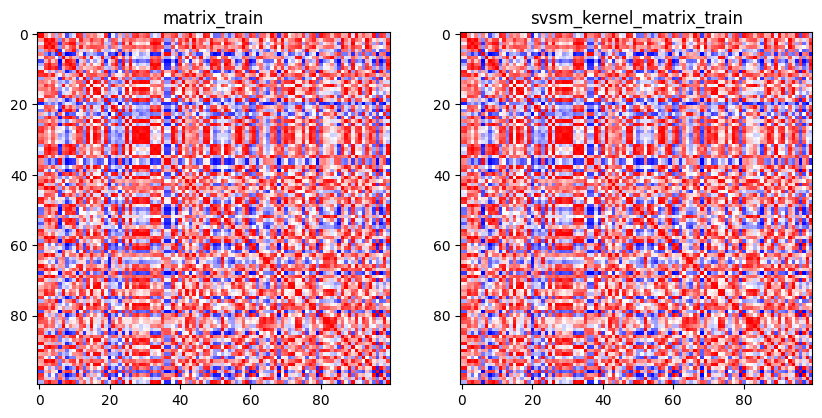

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("matrix_train")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("svsm_kernel_matrix_train")
plt.savefig("{}_matrix.png".format(label_name))
plt.show()



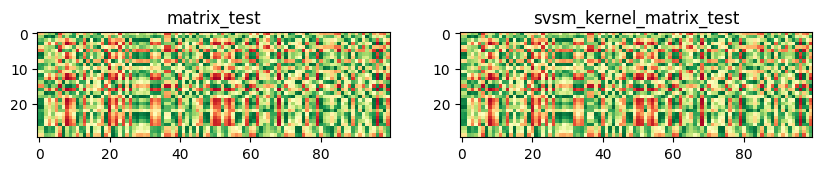

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[0].set_title("matrix_test")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[1].set_title("svsm_kernel_matrix_test")
plt.show()


In [108]:
from sklearn.svm import SVR, NuSVC



In [109]:
svc = SVR(kernel="precomputed")
svc.fit(svsm_kernel_matrix_train,Y_train[:100].values.ravel())
y_pred = svc.predict(svsm_kernel_matrix_train)
result1 = svc.score(svsm_kernel_matrix_train,Y_train[:100].values.ravel())
result2 = svc.score(svsm_kernel_matrix_test,Y_val[:50].values.ravel())
print(result1, result2)


0.5764598669803147 0.6655129590626819


In [123]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.svm import SVR

# 假設 Y_train 和 Y_val 是連續值，我們將它們轉換為離散類別
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Y_train_binned = est.fit_transform(Y_train[:100].values.reshape(-1, 1)).ravel()
Y_val_binned = est.transform(Y_val[:50].values.reshape(-1, 1)).ravel()

# 使用 SVC 進行分類
svc = NuSVC(kernel="precomputed",nu=0.3)
svc.fit(svsm_kernel_matrix_train, Y_train_binned)
y_pred = svc.predict(svsm_kernel_matrix_train)
result1 = svc.score(svsm_kernel_matrix_train, Y_train_binned)
result2 = svc.score(svsm_kernel_matrix_test, Y_val_binned)
print(result1, result2)


0.79 0.8666666666666667


---